In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
from sklearn.model_selection import train_test_split


target = 'Fail'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [0]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [5]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7401479255749451


In [6]:
#1
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [7]:
#2
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [8]:
#3
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Longitude         -0.000589
Zip               -0.000462
AKA Name          -0.000358
Location          -0.000196
Address           -0.000092
City              -0.000058
DBA Name          -0.000046
State              0.000000
Violations         0.000023
Risk               0.000092
Latitude           0.000185
License #          0.000220
Inspection Date    0.000613
Inspection ID      0.000844
Facility Type      0.001375
Inspection Type    0.002658
dtype: float64

In [9]:
#4
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0027 ± 0.0011,Inspection Type
0.0014 ± 0.0009,Facility Type
0.0008 ± 0.0008,Inspection ID
0.0006 ± 0.0007,Inspection Date
0.0002 ± 0.0006,License #
0.0002 ± 0.0009,Latitude
0.0001 ± 0.0008,Risk
0.0000 ± 0.0002,Violations
0 ± 0.0000,State
-0.0000 ± 0.0006,DBA Name


In [10]:
#5
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

#6
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7403790592857968


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85     12830
           1       0.47      0.03      0.06      4476

    accuracy                           0.74     17306
   macro avg       0.61      0.51      0.45     17306
weighted avg       0.67      0.74      0.64     17306



              precision    recall  f1-score   support

           0       0.75      0.99      0.85     12830
           1       0.47      0.03      0.06      4476

    accuracy                           0.74     17306
   macro avg       0.61      0.51      0.45     17306
weighted avg       0.67      0.74      0.64     17306



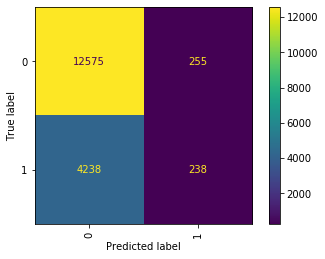

In [12]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

In [13]:
threshold = 0.50
pipeline.predict_proba(X_val)[:, 1] > threshold

array([False, False, False, ..., False, False, False])

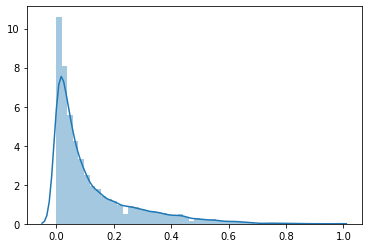

In [14]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

In [0]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

False    17304
True         2
dtype: int64

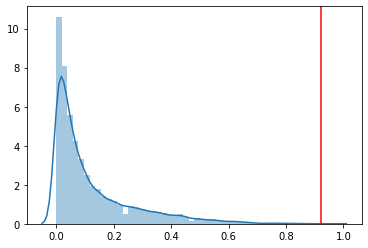

In [16]:
threshold = 0.92

y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [17]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [18]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
results

,y_val,y_pred_proba
15896,1,0.47
21504,0,0.00
32243,0,0.04
29532,0,0.28
9799,0,0.49
...,...,...
37475,1,0.38
6455,0,0.00
388,1,0.02
51909,1,0.10


In [0]:
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]

In [20]:
resturaunts = 2000
print(f'Basseline: {resturaunts * 0.5} inspection failed in {resturaunts} resturaunts')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} inspections failed in {resturaunts} resturaunts')

Basseline: 1000.0 inspection failed in 2000 resturaunts
With model: Predict 820 inspections failed in 2000 resturaunts


In [21]:
precision_at_k_2000 = relevant_recommendations / resturaunts
print('Precision @ k=2000', precision_at_k_2000)

Precision @ k=2000 0.41


In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [23]:
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.96
1,0.000000,0.000223,0.96
2,0.000000,0.000894,0.89
3,0.000000,0.002681,0.84
4,0.000078,0.002904,0.83
...,...,...,...
81,0.602650,0.752681,0.04
82,0.676695,0.817694,0.03
83,0.765238,0.885389,0.02
84,0.875448,0.948838,0.01


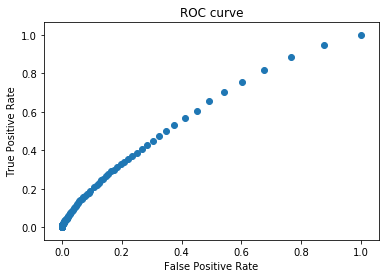

In [24]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.6163126699111291

In [0]:
train['Inspection ID'] = train['Inspection ID'].astype(float)

In [28]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_estimators=200, n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 -0.35007526066099803


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection ID'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


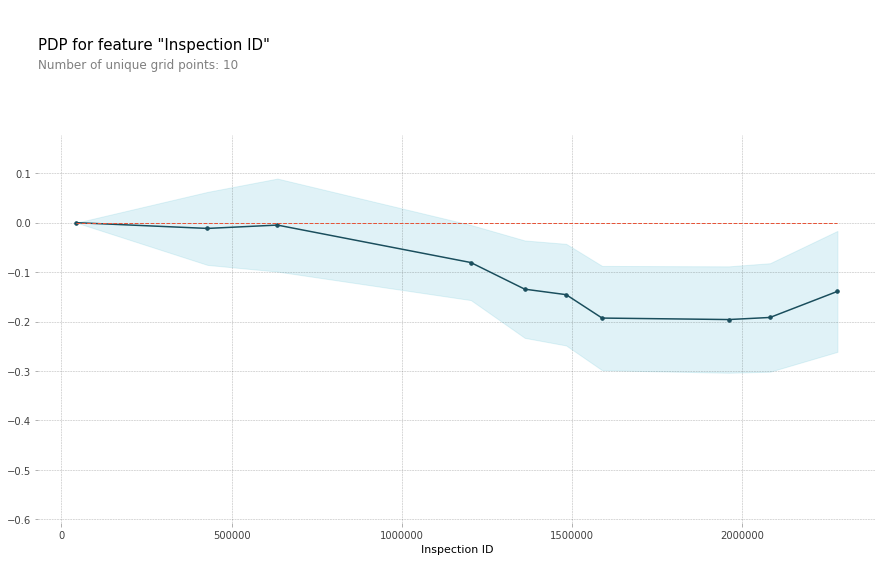

In [31]:
pdp_plot(isolated, feature_name=feature);

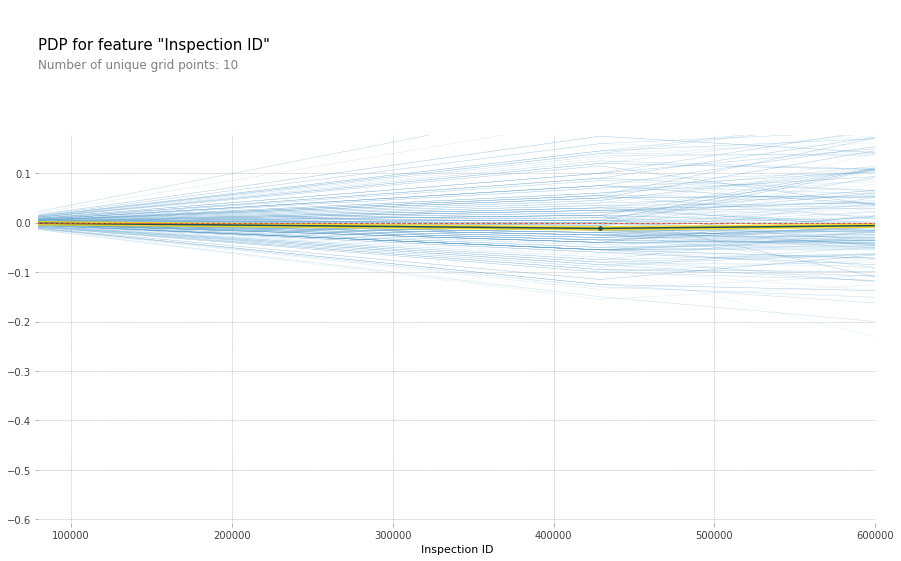

In [32]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)

plt.xlim(80000,600000);

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
X_val['License #'] = pd.Series(X_val['License #'], dtype=object).fillna(0).tolist()

In [0]:
features = ['Inspection ID', 'License #']

In [0]:
interaction = pdp_interact(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns,
    features= features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


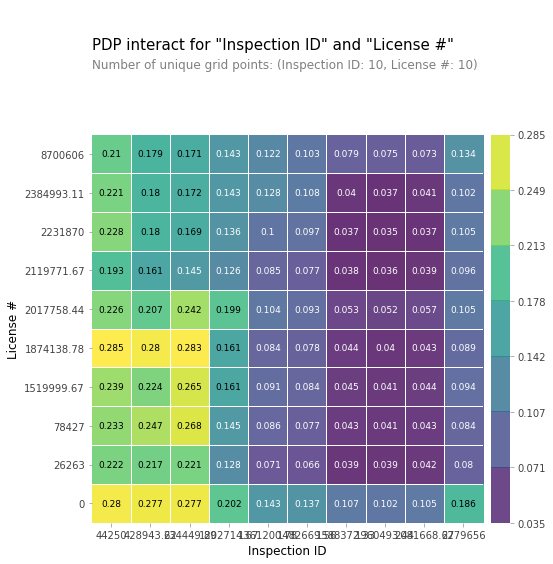

In [45]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [0]:
features = ['Inspection ID']
target = 'Fail'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [96]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   51.3s finished


In [97]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 201}
Cross-validation MAE 0.3661849665282372


In [98]:
row = X_test.iloc[[0]] # Dataframe with a single row (double brackets keeps it a dataframe)
row

,Inspection ID
0,114835


In [99]:
y_test.iloc[[0]]

0    0
Name: Fail, dtype: int64

In [100]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)